# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Importing libraries
import math
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

We start our analysis by separately analysing each of the dataframe and drawing basic plots to better understand the dimensions of the underlying data.

### Portfolio Data 

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# Getting the number of rows and columns in data
portfolio.shape

(10, 6)

In [6]:
# Getting column titles and datatypes alongwith count of non-null entries
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
# Getting unique type of offers that a customer can be given
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

#### Key Takeaways

- The portfolio data has 10 rows and 6 columns.
- There are no null values in any row or column.
- The types of offer given to users are BOGO, Informational and Discount

### Profile Data

In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# Getting the number of rows and columns in data
profile.shape

(17000, 5)

In [10]:
# Getting column titles and datatypes alongwith count of non-null entries
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# Getting sun of null values per column
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
# Finding the unique genders available in our data
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [13]:
# Counting the entries in each gender type
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

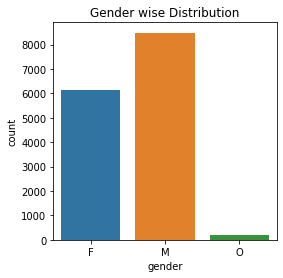

In [14]:
# For a better visual analysis, we plot the distribution of gender on a countplot
plt.figure(figsize=(4 , 4))
sns.countplot(data=profile, x='gender');
plt.title('Gender wise Distribution');

In [15]:
# Analyzing numerical columns for mean and std
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


We now move towards analysing age demographics to see if we can extract any meaningful insights.

In [16]:
profile.age.value_counts().sort_index(ascending=False)

118    2175
101       5
100      12
99        5
98        5
97       13
96        8
95       22
94       33
93       29
92       40
91       47
90       52
89       53
88       64
87       66
86       54
85       70
84       83
83      102
82      105
81      118
80      116
79      117
78      135
77      141
76      155
75      159
74      193
73      209
72      191
71      230
70      252
69      242
68      259
67      317
66      284
65      280
64      311
63      338
62      318
61      309
60      333
59      359
58      408
57      353
56      342
55      350
54      359
53      372
52      351
51      363
50      284
49      321
48      288
47      232
46      212
45      231
44      192
43      215
42      227
41      189
40      202
39      182
38      172
37      197
36      175
35      118
34      147
33      152
32      139
31      113
30      131
29      129
28      137
27      139
26      157
25      136
24      139
23      126
22      131
21      140
20      135
19  

Looks like there are **2175** people who are age **118** using the app. It looks like an odd number in the data. Therefore, we look deep to see if these people have other meaningful information present. 

We filter out these people and observe the missing values.

In [17]:
profile[profile.age ==118].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

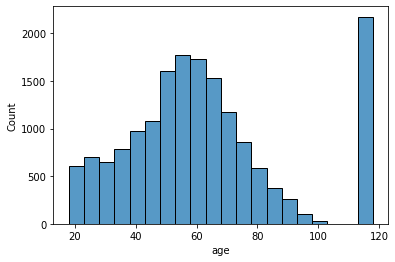

In [18]:
# Making a histogram of the age columns
sns.histplot(data=profile['age'], bins=20);

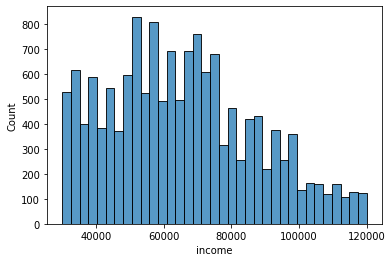

In [19]:
# Analyszing income trends of people using a histogram
sns.histplot(data=profile['income'], bins=35);

### Transcript Data

In [21]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
# Getting the number of rows and columns in data
transcript.shape

(306534, 4)

In [23]:
# Getting column titles and datatypes alongwith count of non-null entries
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
# Looking at the "event" column
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

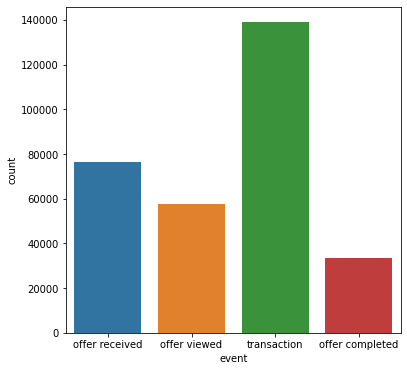

In [25]:
# Analyzing the status of "event" column
plt.figure(figsize=(6 , 6))
sns.countplot(data=transcript, x='event');

In [26]:
# Looking at the record of a random person to see how the transcript data looks like for a person
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


## Data Cleaning / Wrangling

Let's start with **Profile** data by converting the **became_member_on** column to datetime ad separate out membership year for visual analysis.

In [27]:
profile['membership_date'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_year'] = profile['membership_date'].dt.year

profile.head()

,gender,age,id,became_member_on,income,membership_date,membership_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,2017


Moving on to **Transcript** data, we first clean the **value** column by normalizing the json in the column and merging it back with the original data.

In [28]:
# normalizing the json in the "value" column
val_df = pd.json_normalize(transcript['value'])
val_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [29]:
# Looking at datatypes and non null entries in the val_df obtained from "value" column
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  33579 non-null   object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


In [30]:
# checking if both offer_id and offer id are present in a single row
val_df[val_df['offer id'].notnull() & val_df['offer_id'].notnull()]

,offer id,amount,offer_id,reward


In [31]:
# checking when offer_id is present
val_df[val_df['offer_id'].notnull()]

,offer id,amount,offer_id,reward
12658,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
...,...,...,...,...
306475,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306497,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
306506,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306509,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0


The columns `offer_id` and `offer id` are same except for the fact that when the offer is received, the column name is marked as `offer id` and when the offer is completed, the data is present under the name `offer_id` along with a `rewards` column. Therefore, for simplicity purposes, we merge these two column into one.

In [32]:
val_df['offer_id'] = val_df['offer_id'].combine_first(val_df['offer id'])

val_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [33]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  167581 non-null  object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


In [34]:
val_df.shape

(306534, 4)

In [35]:
val_df.drop('offer id', axis=1, inplace=True)
val_df.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [36]:
# concatenating value data back to transcript df but now in separate columns
transcript = pd.concat([transcript, val_df], axis=1)

# dropping the value column
transcript.drop('value', axis=1, inplace=True)

transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [37]:
transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [38]:
# Testing block ------------> Remove in end
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,NaN


Let us now start by merging all dataframes into one big dataframe for final analysis. 
We start by merging `profile` and `transcript` dataframes for offer information and then finally move towards merging `portfolio` data.

In [39]:
df = transcript.merge(portfolio, left_on='offer_id', right_on='id', how='outer')

In [40]:
df.head()

,person,event,time,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [41]:
df.drop('id', axis=1, inplace=True)

In [42]:
df[df['event'] == 'offer completed']         #----------------->Remove in end

,person,event,time,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type
1248,629fc02d56414d91bca360decdfa9288,offer completed,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1254,b860d355ef6e4c66b5d5a837c56ef32d,offer completed,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1255,99297ea01107436fa8c2e2bc86f55d89,offer completed,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1263,16dc4306258b4fef90ffe99f53ed7952,offer completed,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1267,0454292436bd4cee98e8ec873e30433e,offer completed,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
...,...,...,...,...,...,...,...,...,...,...,...
153270,6d9ee24c5889452e800b7d700f29b01e,offer completed,714,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,"[email, mobile, social]",10.0,7.0,bogo
153271,cba7152af9af4f3f95b6a3e4d942cd61,offer completed,714,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,"[email, mobile, social]",10.0,7.0,bogo
153272,f86af496c16140a5a9e4fbe605a27bb5,offer completed,714,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,"[email, mobile, social]",10.0,7.0,bogo
153273,0f1d40baf5fd438ea8d699a721467c1b,offer completed,714,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,"[email, mobile, social]",10.0,7.0,bogo


In [43]:
df2  = df.merge(profile, left_on='person', right_on='id', how='outer')
df2.head()

,person,event,time,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,gender,age,id,became_member_on,income,membership_date,membership_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017


In [44]:
df2.head()

,person,event,time,amount,offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,gender,age,id,became_member_on,income,membership_date,membership_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017


In [45]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   amount            138953 non-null  float64       
 4   offer_id          167581 non-null  object        
 5   reward_x          33579 non-null   float64       
 6   reward_y          167581 non-null  float64       
 7   channels          167581 non-null  object        
 8   difficulty        167581 non-null  float64       
 9   duration          167581 non-null  float64       
 10  offer_type        167581 non-null  object        
 11  gender            272762 non-null  object        
 12  age               306534 non-null  int64         
 13  id                306534 non-null  object        
 14  beca

In [46]:
df2.drop(columns=['id', 'became_member_on', 'channels'], axis=1, inplace=True)
df2.head()

,person,event,time,amount,offer_id,reward_x,reward_y,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017


In [47]:
df2.shape

(306534, 15)

In [48]:
df2.drop(df2[df2['age'] == 118].index, inplace=True)

In [49]:
df2.shape

(272762, 15)

In [50]:
df2.describe()

,time,amount,reward_x,reward_y,difficulty,duration,age,income,membership_year
count,272762.000000,123957.000000,32444.000000,148805.000000,148805.000000,148805.000000,272762.000000,272762.000000,272762.000000
mean,366.707694,13.996325,4.948249,4.442445,7.890561,6.625207,53.840696,64337.000755,2016.457435
std,200.359087,31.749420,2.905376,3.372362,5.041335,2.133035,17.551337,21243.762941,1.218663
min,0.000000,0.050000,2.000000,0.000000,0.000000,3.000000,18.000000,30000.000000,2013.000000
25%,186.000000,3.660000,2.000000,2.000000,5.000000,5.000000,41.000000,48000.000000,2016.000000
50%,408.000000,10.800000,5.000000,5.000000,10.000000,7.000000,55.000000,62000.000000,2017.000000
75%,528.000000,19.130000,5.000000,5.000000,10.000000,7.000000,66.000000,78000.000000,2017.000000
max,714.000000,1062.280000,10.000000,10.000000,20.000000,10.000000,101.000000,120000.000000,2018.000000


In [52]:
df2.rename(columns={'reward_x': 'reward_received', 'reward_y': 'offer_reward'}, inplace=True)


In [53]:
df2.head()

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017


In [54]:
bins = [17, 30, 50, 75, 110]
category = ['Youth', 'Adult', 'Senior', 'Old']
df2['age_group'] = pd.cut(df2['age'], bins, labels=category)

In [55]:
df2.head()

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior


In [56]:
bins = [0, 40000, 80000, 130000]
category = ['Low', 'Middle', 'High']
df2['income_group'] = pd.cut(df2['income'], bins, labels=category)

In [57]:
df2.head()

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group,income_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High


### What kind of offers are sent to each demographic group?

We start by analyzing the type of offers sent to each kind of our population distribution group, i.e. by gender, by age and by income.


In [59]:
df2.shape

(272762, 17)

In [60]:
def plot_offer_type_distribution(data, x=None, hue=None, title=None):
    """
    Plots Number of offers sent to each type of population demographic
    
    :param data: dataframe
    :param hue: list
    :param x: string
    :param title: string
    :return: None
    """
    
    plt.figure(figsize=(5 , 5))
    ax = sns.countplot(data=data, x=x, hue=hue)
    ax.set(xlabel='Offer Type', ylabel='Number of People', title=title)
    plt.show()

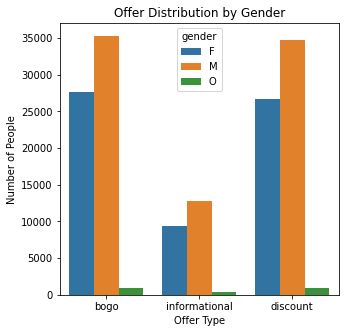

In [61]:
plot_offer_type_distribution(data=df2, x='offer_type', hue='gender', title='Offer Distribution by Gender')


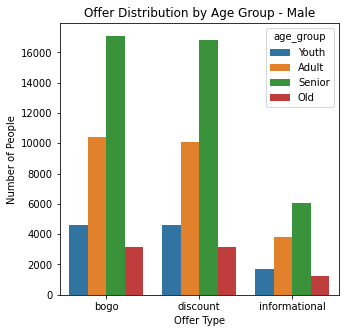

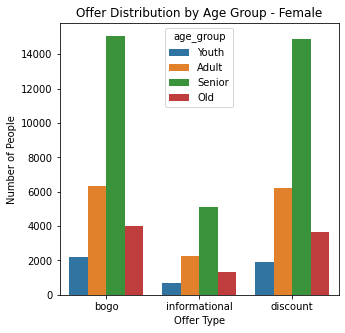

In [62]:
plot_offer_type_distribution(data=df2[df2.gender == 'M'], x='offer_type', hue='age_group', title='Offer Distribution by Age Group - Male')
plot_offer_type_distribution(data=df2[df2.gender == 'F'], x='offer_type', hue='age_group', title='Offer Distribution by Age Group - Female')

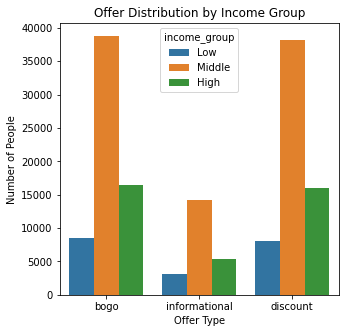

In [63]:
plot_offer_type_distribution(data=df2, x='offer_type', hue='income_group', title='Offer Distribution by Income Group')

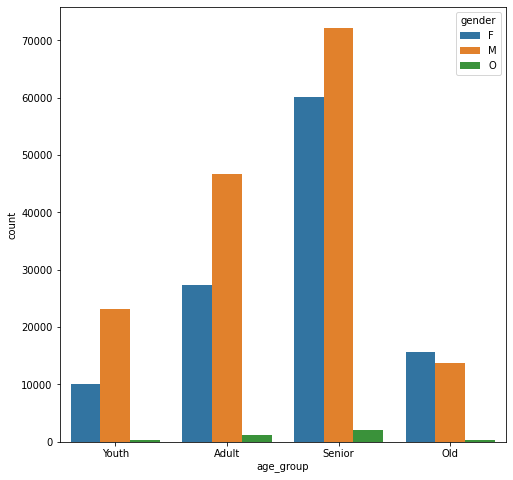

In [64]:
# Dist of Age group wrt gender  -----------------> remove if not req at end
plt.figure(figsize=(8 , 8))
ax = sns.countplot(data=df2, x='age_group', hue='gender')
# ax.set(xlabel='Months', ylabel='Number of items added', title='Media Added per Month on Netflix')
plt.show()

In [65]:
df2.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [66]:
df2[df2.gender == 'M'].offer_type.value_counts()

bogo             35301
discount         34739
informational    12856
Name: offer_type, dtype: int64

In [67]:
df2.isna().sum()

person                  0
event                   0
time                    0
amount             148805
offer_id           123957
reward_received    240318
offer_reward       123957
difficulty         123957
duration           123957
offer_type         123957
gender                  0
age                     0
income                  0
membership_date         0
membership_year         0
age_group               0
income_group            0
dtype: int64

In [68]:
df2[df2.event == 'transaction']

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group,income_group
11,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,NaN,NaN,NaN,NaN,F,75,100000.0,2017-05-09,2017,Senior,High
12,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,NaN,NaN,NaN,NaN,F,75,100000.0,2017-05-09,2017,Senior,High
13,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,NaN,NaN,NaN,NaN,NaN,F,75,100000.0,2017-05-09,2017,Senior,High
14,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,NaN,NaN,NaN,NaN,NaN,F,75,100000.0,2017-05-09,2017,Senior,High
15,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,NaN,NaN,NaN,NaN,NaN,F,75,100000.0,2017-05-09,2017,Senior,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306528,ae8111e7e8cd4b60a8d35c42c1110555,transaction,636,9.72,NaN,NaN,NaN,NaN,NaN,NaN,F,54,72000.0,2017-01-06,2017,Senior,Middle
306529,ae8111e7e8cd4b60a8d35c42c1110555,transaction,654,18.97,NaN,NaN,NaN,NaN,NaN,NaN,F,54,72000.0,2017-01-06,2017,Senior,Middle
306530,3a4874d8f0ef42b9a1b72294902afea9,transaction,324,22.75,NaN,NaN,NaN,NaN,NaN,NaN,F,55,88000.0,2016-08-16,2016,Senior,High
306531,3a4874d8f0ef42b9a1b72294902afea9,transaction,378,27.20,NaN,NaN,NaN,NaN,NaN,NaN,F,55,88000.0,2016-08-16,2016,Senior,High


### How are the people likely to respond to each offer type

In [69]:
df2.query('offer_type == "informational" & event == "offer completed"')

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group,income_group


We now want to analyze how many people actually viewed and then completed an offer. For this we will filter out the rows where a **transaction** event took place. We will also drop the rows with **informational** offer as it is just to be viewed and has no way of completion.

In [70]:
offer_df = df2.query('event != "transaction" & offer_type != "informational"')

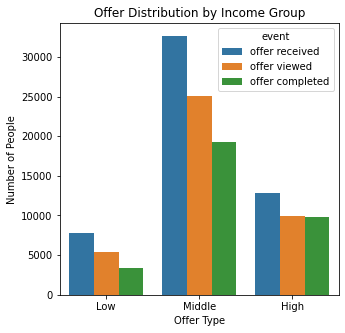

In [71]:
plot_offer_type_distribution(data=offer_df, x='income_group', hue='event', title='Offer Distribution by Income Group')

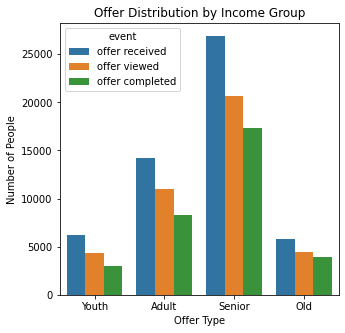

In [72]:
plot_offer_type_distribution(data=offer_df, x='age_group', hue='event', title='Offer Distribution by Income Group')

In [73]:
offer_df[offer_df['person'] == '78afa995795e4d85b5d9ceeca43f5fef'].sort_values(by=['time'])

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group,income_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
6,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
7,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
8,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,10.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
5,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,582,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High


In [74]:
offer_df[offer_df['person'] == 'e2127556f4f64592b11af22de27a7932'].sort_values(by=['time'])

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group,income_group
64807,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,M,68,70000.0,2018-04-26,2018,Senior,Middle
64808,e2127556f4f64592b11af22de27a7932,offer viewed,18,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,M,68,70000.0,2018-04-26,2018,Senior,Middle
64804,e2127556f4f64592b11af22de27a7932,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,M,68,70000.0,2018-04-26,2018,Senior,Middle
64805,e2127556f4f64592b11af22de27a7932,offer viewed,420,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,7.0,bogo,M,68,70000.0,2018-04-26,2018,Senior,Middle
64809,e2127556f4f64592b11af22de27a7932,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,discount,M,68,70000.0,2018-04-26,2018,Senior,Middle
64806,e2127556f4f64592b11af22de27a7932,offer completed,522,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,M,68,70000.0,2018-04-26,2018,Senior,Middle
64810,e2127556f4f64592b11af22de27a7932,offer viewed,522,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,10.0,discount,M,68,70000.0,2018-04-26,2018,Senior,Middle
64811,e2127556f4f64592b11af22de27a7932,offer completed,522,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,2.0,10.0,10.0,discount,M,68,70000.0,2018-04-26,2018,Senior,Middle


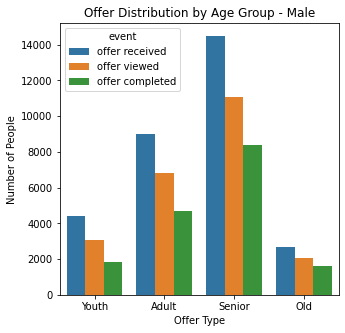

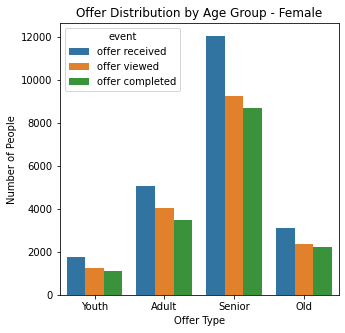

In [76]:
plot_offer_type_distribution(data=offer_df[offer_df.gender == 'M'], x='age_group', hue='event', title='Offer Distribution by Age Group - Male')
plot_offer_type_distribution(data=offer_df[offer_df.gender == 'F'], x='age_group', hue='event', title='Offer Distribution by Age Group - Female')

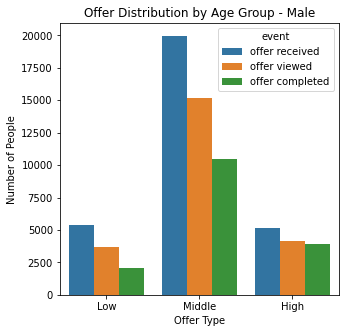

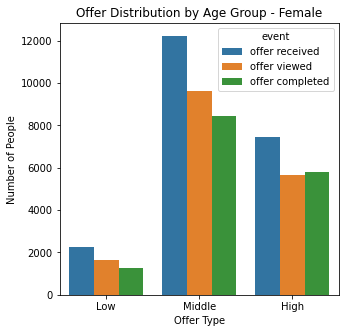

In [77]:
plot_offer_type_distribution(data=offer_df[offer_df.gender == 'M'], x='income_group', hue='event', title='Offer Distribution by Age Group - Male')
plot_offer_type_distribution(data=offer_df[offer_df.gender == 'F'], x='income_group', hue='event', title='Offer Distribution by Age Group - Female')

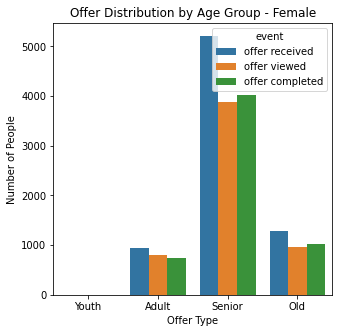

In [88]:
plot_offer_type_distribution(data=offer_df.query('gender == "F" & income > 80000'), x='age_group', hue='event', title='Offer Distribution by Age Group - Female')

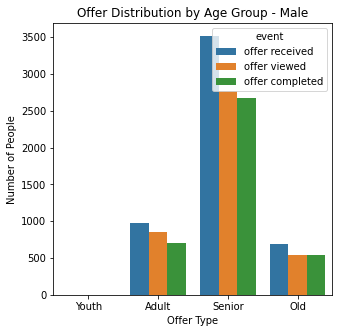

In [89]:
plot_offer_type_distribution(data=offer_df.query('gender == "M" & income > 80000'), x='age_group', hue='event', title='Offer Distribution by Age Group - Male')

### Ratio of people joining the Starbucks app

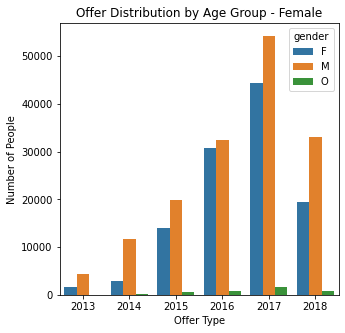

In [91]:
plot_offer_type_distribution(data=df2, x='membership_year', hue= 'gender', title='Offer Distribution by Age Group - Female')

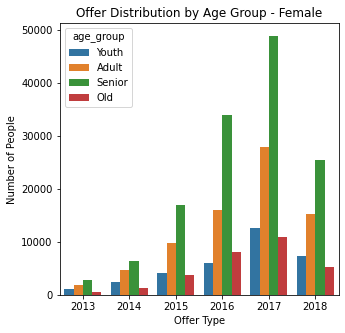

In [92]:
plot_offer_type_distribution(data=df2, x='membership_year', hue= 'age_group', title='Offer Distribution by Age Group - Female')

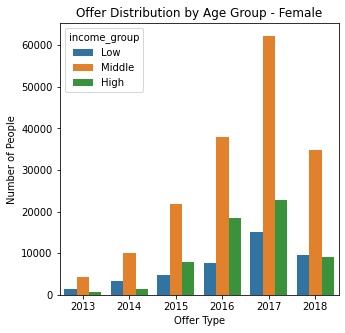

In [93]:
plot_offer_type_distribution(data=df2, x='membership_year', hue= 'income_group', title='Offer Distribution by Age Group - Female')

### What offers are most likely to be completed

In [94]:
offer_df = offer_df[offer_df.event == 'offer completed']

In [95]:
offer_df.head()

,person,event,time,amount,offer_id,reward_received,offer_reward,difficulty,duration,offer_type,gender,age,income,membership_date,membership_year,age_group,income_group
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,5.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,5.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
8,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,10.0,7.0,bogo,F,75,100000.0,2017-05-09,2017,Senior,High
23,ebe7ef46ea6f4963a7dd49f501b26779,offer completed,432,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,2.0,10.0,7.0,discount,M,59,41000.0,2015-01-21,2015,Senior,Middle
26,ebe7ef46ea6f4963a7dd49f501b26779,offer completed,300,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,2.0,10.0,10.0,discount,M,59,41000.0,2015-01-21,2015,Senior,Middle


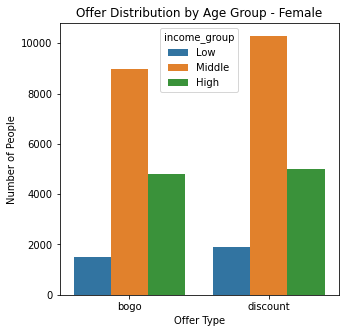

In [97]:
plot_offer_type_distribution(data=offer_df, x='offer_type', hue= 'income_group', title='Offer Distribution by Age Group - Female')

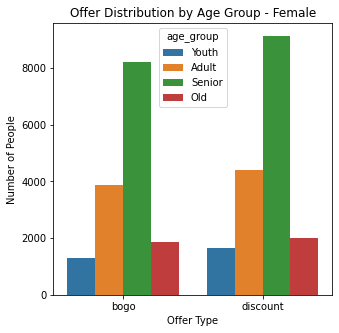

In [98]:
plot_offer_type_distribution(data=offer_df, x='offer_type', hue= 'age_group', title='Offer Distribution by Age Group - Female')

### Spending tracker

In [136]:
groups = df2[df2['gender'] != 'O'].groupby(['gender', 'age_group', 'income_group'])['amount'].mean()

In [137]:
spending

income_group
Low        6.198411
Middle    12.094123
High      28.394274
Name: amount, dtype: float64

In [138]:
spending = df2.groupby(['income_group'])['amount'].mean()

In [139]:
spending

income_group
Low        6.198411
Middle    12.094123
High      28.394274
Name: amount, dtype: float64

<AxesSubplot:xlabel='gender,age_group,income_group'>

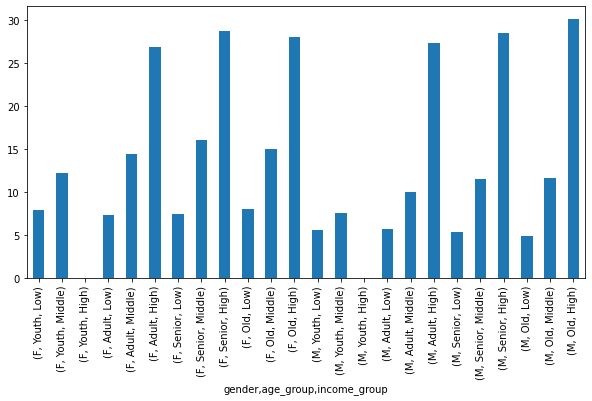

In [140]:
plt.figure(figsize=(10 , 5))
groups.plot.bar()

In [141]:
groups2 = df2[df2['gender'] != 'O'].groupby(['gender', 'age_group', 'income_group'])['amount'].sum()

<AxesSubplot:xlabel='gender,age_group,income_group'>

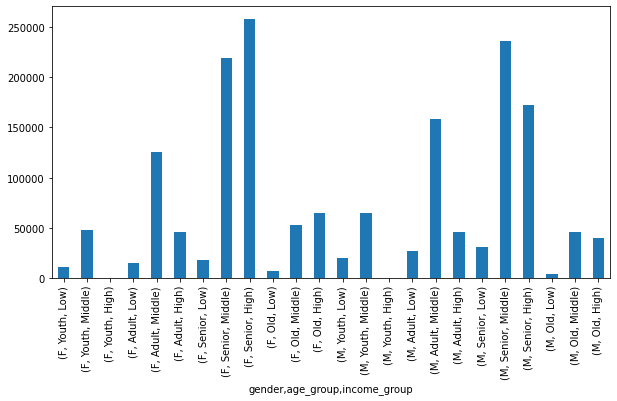

In [142]:
plt.figure(figsize=(10 , 5))
groups2.plot.bar()